# Building a ML Model for the MNIST Dataset

Steps to carry out:
1. Get the MNIST Dataset
2. Build a CNN Model
3. Train the model
4. Make predictions, evaluate the results and visualize (confusion matrix)

In [56]:
# Importing Modules
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.2.1+cu121'

In [57]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Get the MNIST Dataset

## Download the dataset, and view some random examples

In [58]:
# Import dependencies for getting datasets
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# check version
torchvision.__version__

'0.17.1+cu121'

In [59]:
# setup training data
train_data = datasets.MNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
  target_transform=None
)

# setup testing data
test_data = datasets.MNIST(
  root="data",
  train=False,
  download=True,
  transform=ToTensor(),
  target_transform=None
)

In [60]:
# check lengths of dataset
len(train_data), len(test_data)

(60000, 10000)

Image shape: torch.Size([1, 28, 28])
Label: 4


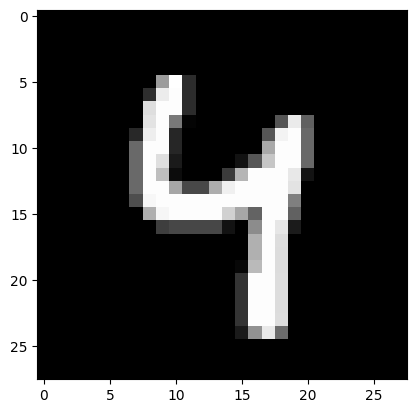

In [61]:
# import the first image
import random

# set variables
img, label = train_data[random.randint(0, len(train_data))]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")

# display image
plt.imshow(img[0], cmap="gray")

In [62]:
# setting classes to a variable
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Create train and test DataLoaders

In [63]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# turn data into iterables
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fcc82d0e1a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcc82d0e7a0>)

# Build a Model

- Will be building a CNN, or Convolutional Neural Network.

In [64]:
class MNISTModelV0(nn.Module):
  def __init__(self, in_features: int, hidden_units: int, out_features: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=in_features,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(
          in_channels=hidden_units,
          out_channels=hidden_units,
          kernel_size=3,
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(
          in_channels=hidden_units,
          out_channels=hidden_units,
          kernel_size=3,
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7, out_features=out_features)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

## Instantiate CNN Model

In [65]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

# instantiate CNN model
model_0 = MNISTModelV0(
  in_features=1,
  hidden_units=16,
  out_features=len(class_names)
)

model_0

MNISTModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

# Train and Test the model

## Pre-requisites

Will need:
1. Loss function
2. optimizer
3. accuracy function (import from helper_functions)
4. train and test step
5. model evaluation function

### Loss function and optimizer

In [66]:
# setting loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
  params=model_0.parameters(),
  lr=0.1
)

### Accuracy Function from `helper_functions`

In [67]:
# Importing accuracy_fn from helper functions

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


### Train and test step functions

In [68]:
# Define Taining Step
def train_step(
  model: torch.nn.Module,
  data_loader: torch.utils.data.DataLoader,
  loss_fn: torch.nn.Module,
  optimizer: torch.optim.Optimizer,
  accuracy_fn,
  device: torch.device = device
):
  """Performs a training with model trying to learn on our data_loader"""

  train_loss, train_acc = 0, 0

  # put model in train mode
  model.train()

  # add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # put data on target device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

  # Calculate average training loss (epoch level)
  # divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  # Print out whats happening
  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%\n")

In [69]:
# Define Testing Step
def test_step(
  model: torch.nn.Module,
  data_loader: torch.utils.data.DataLoader,
  loss_fn: torch.nn.Module,
  optimizer: torch.optim.Optimizer,
  accuracy_fn,
  device: torch.device = device
):
  """Performs a testing loop on model going over our data_loader"""

  # Testitng
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X, y in data_loader:
      # Putting data on device
      X, y = X.to(device), y.to(device)

      # forward pass
      test_pred = model(X)

      # calculate loss
      test_loss += loss_fn(test_pred, y)

      # calculate accuracy
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # calculate the test loss average per batch
    test_loss /= len(data_loader)

    # calculaty the test acc average per batch
    test_acc /= len(data_loader)

    # print out whats happening
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")

### Model eval function

In [70]:
torch.manual_seed(42)

def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device = None
):
  """Return a dictionary containing the results of model predicting on data loader"""
  loss, acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # set data on device
      if device:
        X, y = X.to(device), y.to(device)
      else:
        pass

      # make predictions
      y_pred = model(X)

      # Accumulate loss and accuracy values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale the loss and acc to find average values
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
      "model_name": model.__class__.__name__,
      "model_loss": loss.item(),
      "model_acc": acc
  }

## Training and Testing the CNN Model

In [72]:
# set seeds
torch.manual_seed(28)
torch.cuda.manual_seed(28)

# set epochs
epochs = 3

# import progress bar
from tqdm.auto import tqdm

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")

  # Train
  train_step(
    model=model_0,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn
  )

  # Test
  test_step(
      model=model_0,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn
  )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.0946, Train Acc: 97.03%

Test Loss: 0.0501, Test Acc: 98.47%

Epoch: 1
Train Loss: 0.0554, Train Acc: 98.31%

Test Loss: 0.0497, Test Acc: 98.39%

Epoch: 2
Train Loss: 0.0422, Train Acc: 98.66%

Test Loss: 0.0333, Test Acc: 98.97%



## Evaluate Trained Model

In [74]:
model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'MNISTModelV0',
 'model_loss': 0.03326793387532234,
 'model_acc': 98.97164536741214}

# Visualizing confusion Matrix of model

## Make predictions

In [75]:
y_preds = []

model_0.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    # putting to device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_logits = model_0(X)

    # converting them to labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

  # convert list to tensor
  y_preds = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

## Create and Plotting Confusion Matrix

In [76]:
# insall torchmetrics
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [77]:
# importing mlxtend
import mlxtend
mlxtend.__version__

'0.22.0'

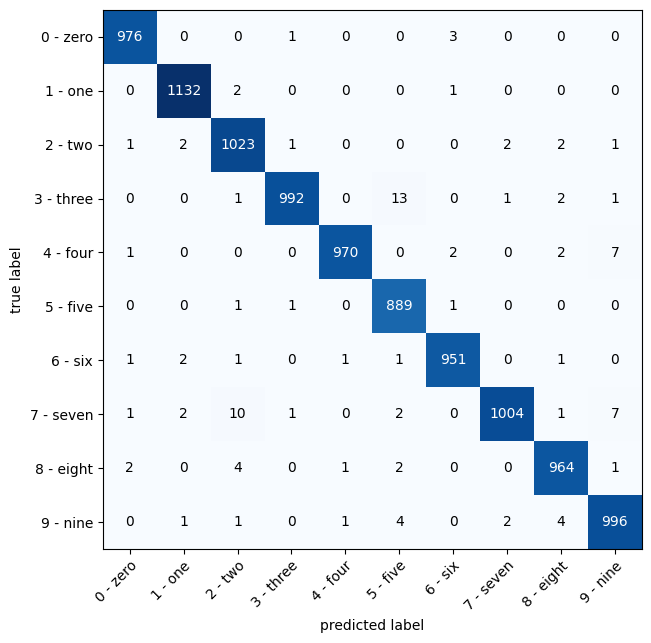

In [78]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_preds, target=test_data.targets)

fig, ax = plot_confusion_matrix(
  conf_mat=confmat_tensor.numpy(),
  class_names=class_names,
  figsize=(10, 7)
)